In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas._libs.tslibs import dtypes, timestamps
import subprocess

In [24]:
model = "resnet50"
n_epochs = "2"
batch_size = "64"
save_every = "1"
log = "true"

stat_dir = "/home/gsd/andrelucena/statistics"
stat_test = "eBPFs_subset"
test_name = model + "_" + n_epochs + "_" + batch_size + "_" + save_every + "_" + log
full_test_path = stat_dir + "/" + stat_test + "/" + test_name + "/"

p = subprocess.Popen(["scp", f"aurora:{full_test_path}/out.out", "./tmp/file"])
sts = os.waitpid(p.pid, 0)

df = pd.read_csv("./tmp/file", skiprows=[0,1,2,3,4], names=['system_time'], index_col=False, delimiter='/')

os.remove("./tmp/file")

df = df['system_time'].str.extract(r'(?P<system_time>[^:]*:[^:]*:[^:\.]*)\.[^:]*:(?P<action>.*)')
df = df.dropna()
print(df.head())

                   system_time                                    action
0          2024-11-04 21:06:03                            Training begin
1          2024-11-04 21:06:03                          Training epoch 1
3          2024-11-04 21:06:04                Start Training Iteration 0
4          2024-11-04 21:06:04   Moving data to the same device as model
5          2024-11-04 21:06:04                          Computing output


/tmp/ipykernel_169626/2702433322.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


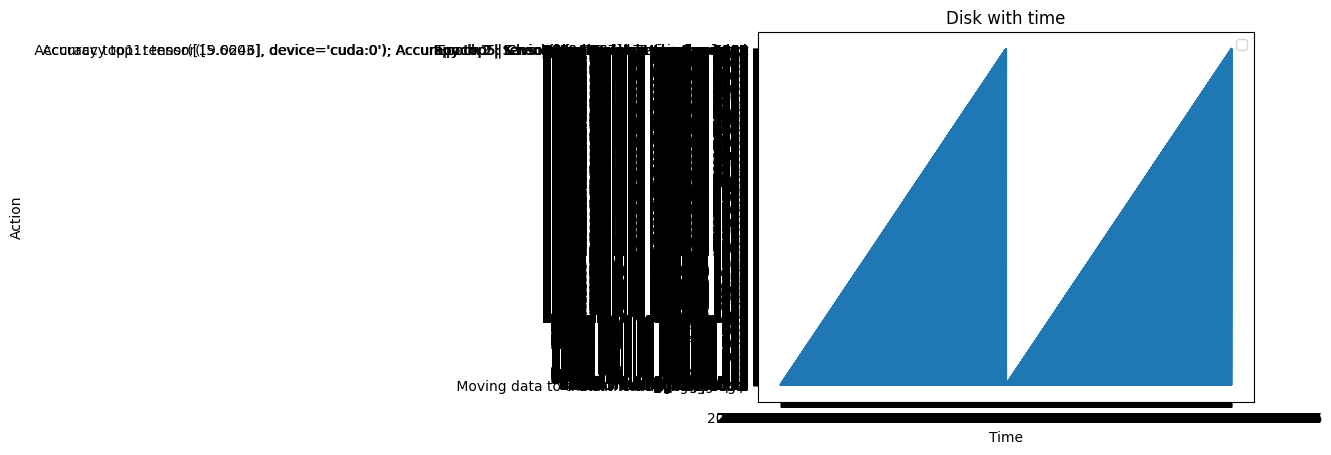

In [ ]:
# plots action with time
plt.figure()
plt.plot(df['system_time'], df['action'])
plt.xlabel('Time')
plt.ylabel('Action')
plt.title('Action per time')
#plt.legend()
plt.show()